# *NFL combine positionsanalyse - R analyse*

Link til colab: https://colab.research.google.com/drive/1xeA_oGZhXaQ0eCSZd92YK8BF6zDHUPkZ

Meningen med denne analyse er, at prøve at finde en sammenhæng mellem en spillers fysiske karakteristika og dennes position. I Amerikansk fodbold er der 25 forskellige pladser med deres egne notationer. Udfra et datasæt om combine data (Den fysiske evaluering før en spiller rekuteres), vil denne analyse blive lavet. Her er hovedmålet at se, om en spiller faktisk spiller på den rigtige position i forhold til hvad algoritmen fortæller personen skal spille, samt om der ses ligheder internt i dataet, i form af, at flere positioner ligner hinanden (Center og Guard, Wide receiver og Corner back, Tight end og Defensive End etc.).

Der laves 2 beskrevne analyser og en analyse for nysgerrighedens skyld, en på baggrund af de normale positioner datasættet indeholder, og en på baggrund af kombinationer af positioner. Det er sådan, at datasættet indeholder "underpositioner" af allerede kendte posiitoner, som har meget lave observationer, som EDGE der er en undergruppering af DE, og NT der er en undergruppering af DT, her kombineres disse posiitoner, så, når der fjernes NA, mistes der ikke alt for mange observationer for disse undergrupper. Til sidst laves en lille analyse som inddeler positionerne efter om de er "tunge drenge" med høj stødkraft men lav mobilitet, medium drenge med lidt vægt som stadig er semi-mobile samt de lette drenge som har høj mobilitet men ingen vægt bag sig.

Den største fejlkilde vi har i projektet er vores prediction test og dets konklusion igennem en confusionmatrix. Vores problemstilling er, om vi kan prediktere hvad en spiller skulle spille, på vegne af spillerens fysiske mål, hvilket, desværre, også kan inkludere om spilleren spiller på sin rigtige position. Teoretisk set kunne en spiller godt spille på en position som spilleren ikke er "fysisk egnet" til, i forhold til de resterende spillere. 

Vi installere pakkerne:

In [0]:
#install.packages("FactoMineR")
#install.packages("factoextra")
#library(devtools)
#install_github("vqv/ggbiplot")
#install.packages("GGally")
#install.packages("caret")
#install.packages("recipes")
#install.packages("rpart")
#install.packages('e1071', dependencies=TRUE)
#install.packages("ranger")
#install.packages("kernlab")
#install.packages("gbm")
#install.packages("MLmetrics")
#install.packages("kknn")

Vi benytter pakkerne:

In [0]:
library(tidyverse)
library(magrittr)
library(lubridate)
library(FactoMineR)
library(factoextra)
library(ggbiplot)
library(GGally)
library(caret)
library(recipes)
library(rpart)
library(e1071)
library(ranger)
library(kernlab)
library(gbm)
library(MLmetrics)
library(kknn)

Nu indlæses vores data, der fjernes variable vi ikke har brug for, samt konvertere variablerne til metric units i stedet for "freedom units"(Imperial units) :D

Der dannes en vars_num som der arbejdes med løbende igennem projektet. Disse er variablerne vi vil inkludere i analysen, med numerisk værdi.

dataframen "data" er vores første analyse, uden kombination, hvor vi subsetter nogen positioner med for få observtioner. 

dataframen "data2" er vores anden analyse, med kombination, hvor vi kombinere positioner af ligende stilling og subsetter positioner med for få observationer. 

Grunden til at data2 er defineret før data er, at vi vil lave data2 på baggrund af det rå datasæt, hvor vi overskriver variablen senere. 

In [0]:
data <- read_csv("https://github.com/bande15/sds/raw/master/combine_data.csv")

data %>% head()
count(data$Pos)


#Data hvor kombinatiooner er kombineret. EDGE er inkluderet i DE. OLB og ILB er inkluderet i OL. NT er inkluderet i DT. FS og SS er inkluderet i s. NS er inkluderet i G. Tilsidst er LB og P fjernet grundet 1 observation.
data2 <- data %>% select(-Player, -Year, -Team, -AV, -Round, -Pick, -Pfr_ID)
data2 %<>% mutate(data2, Pos = fct_recode(Pos, "DE" = "EDGE")) %>% mutate(data2, Pos = fct_recode(Pos, "OL" = "OLB")) %>% mutate(data2, Pos = fct_recode(Pos, "OL" = "ILB")) %>% mutate(data2, Pos = fct_recode(Pos, "DT" = "NT")) %>% mutate(data2, Pos = fct_recode(Pos, "S" = "SS")) %>% mutate(data2, Pos = fct_recode(Pos, "S" = "FS")) %>% mutate(data2, Pos = fct_recode(Pos, "G" = "LS")) %>% subset(Pos != "LB" & Pos != "P" & Pos != "K" & Pos != "DB") %>% drop_na()
nrow(data2)
count(data2$Pos)

#Normal analyse, hvor vi har fjernet LS, QB, LB, OL, S, G og EDGE grundet lave antal observationer.
data %<>% select(-Player, -Year, -Team, -AV, -Round, -Pick, -Pfr_ID) %>% drop_na() %>% subset(Pos !="LS" & Pos != "QB" & Pos != "LB" & Pos != "OL" & Pos != "S" & Pos != "G" & Pos != "EDGE")
nrow(data)
count(data$Pos)

vars_num <- c("Ht", "Wt", "Forty", "Vertical", "BenchReps", "BroadJump", "Cone", "Shuttle")

data$Wt <- data$Wt*0.45
data$Ht <- data$Ht*2.54
data$Vertical <- data$Vertical*2.54
data$BroadJump <- data$BroadJump*2.54

Parsed with column specification:
cols(
  Player = col_character(),
  Pos = col_character(),
  Ht = col_double(),
  Wt = col_double(),
  Forty = col_double(),
  Vertical = col_double(),
  BenchReps = col_double(),
  BroadJump = col_double(),
  Cone = col_double(),
  Shuttle = col_double(),
  Year = col_double(),
  Pfr_ID = col_character(),
  AV = col_double(),
  Team = col_character(),
  Round = col_double(),
  Pick = col_double()
)


Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
John Abraham,OLB,76,252,4.55,NA,NA,NA,NA,NA,2000,AbraJo00,26,New York Jets,1,13
Shaun Alexander,RB,72,218,4.58,NA,NA,NA,NA,NA,2000,AlexSh00,26,Seattle Seahawks,1,19
Darnell Alford,OT,76,334,5.56,25,23,94,8.48,4.98,2000,AlfoDa20,0,Kansas City Chiefs,6,188
Kyle Allamon,TE,74,253,4.97,29,NA,104,7.29,4.49,2000,NA,0,NA,NA,NA
Rashard Anderson,CB,74,206,4.55,34,NA,123,7.18,4.15,2000,AndeRa21,6,Carolina Panthers,1,23
Jake Arians,K,70,202,NA,NA,NA,NA,NA,NA,2000,arianjak01,0,NA,NA,NA


x,freq
<fct>,<int>
C,171
CB,630
DB,2
DE,487
DT,463
EDGE,23
FB,117
FS,229
G,14


[1] 2884

x,freq
<fct>,<int>
C,115
CB,311
DE,287
DT,253
FB,77
S,237
G,10
OL,371
OG,224


[1] 2846

x,freq
<fct>,<int>
C,115
CB,311
DE,279
DT,253
FB,77
FS,123
ILB,130
OG,224
OLB,240


# *DEL 1.1 - Unsurpervised analyse af datasæt, UDEN kombination af positioner*


Her laves en unsupervised analyse af datasættet, uden kombination af positioner. 

Vi anser dataet, her observerer vi hurtigt at de numeriske variabler og variablen Pos er inkluderet, deres modus samt antallet af de forskellige positioner for at sikre, at alle positioner med få værdier er filtreret fra. 

In [0]:
data %>% glimpse()
data %>% head()
sapply(data, mode)

count(data$Pos)

Observations: 2,846
Variables: 9
$ Pos       <chr> "OT", "OLB", "CB", "OT", "FS", "CB", "FS", "OG", "ILB", "DE…
$ Ht        <dbl> 193.04, 182.88, 175.26, 198.12, 182.88, 177.80, 185.42, 193…
$ Wt        <dbl> 150.30, 106.65, 78.75, 140.40, 93.60, 89.55, 93.15, 135.90,…
$ Forty     <dbl> 5.56, 4.72, 4.44, 5.34, 4.62, 4.44, 4.62, 5.07, 4.78, 5.09,…
$ Vertical  <dbl> 63.50, 78.74, 88.90, 71.12, 88.90, 95.25, 100.33, 80.01, 80…
$ BenchReps <dbl> 23, 21, 17, 20, 10, 16, 15, 17, 21, 26, 12, 28, 14, 14, 28,…
$ BroadJump <dbl> 238.76, 284.48, 302.26, 243.84, 289.56, 294.64, 302.26, 261…
$ Cone      <dbl> 8.48, 7.96, 7.03, 7.72, 6.92, 6.81, 6.48, 7.76, 7.17, 7.68,…
$ Shuttle   <dbl> 4.98, 4.39, 4.14, 4.73, 4.32, 4.04, 4.29, 4.58, 4.33, 4.49,…


Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OT,193.04,150.30,5.56,63.50,23,238.76,8.48,4.98
OLB,182.88,106.65,4.72,78.74,21,284.48,7.96,4.39
CB,175.26,78.75,4.44,88.90,17,302.26,7.03,4.14
OT,198.12,140.40,5.34,71.12,20,243.84,7.72,4.73
FS,182.88,93.60,4.62,88.90,10,289.56,6.92,4.32
CB,177.80,89.55,4.44,95.25,16,294.64,6.81,4.04


Pos          Ht          Wt       Forty    Vertical   BenchReps 
"character"   "numeric"   "numeric"   "numeric"   "numeric"   "numeric" 
  BroadJump        Cone     Shuttle 
  "numeric"   "numeric"   "numeric"

x,freq
<fct>,<int>
C,115
CB,311
DE,279
DT,253
FB,77
FS,123
ILB,130
OG,224
OLB,240


Vi laver nu en PCA analyse og bestemmer optimale antal clusters, hvilket vi får til 2:

Importance of components:
                          PC1    PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     2.3682 0.9223 0.78874 0.61423 0.46865 0.3721 0.34729
Proportion of Variance 0.7011 0.1063 0.07776 0.04716 0.02745 0.0173 0.01508
Cumulative Proportion  0.7011 0.8074 0.88515 0.93231 0.95976 0.9771 0.99214
                           PC8
Standard deviation     0.25073
Proportion of Variance 0.00786
Cumulative Proportion  1.00000

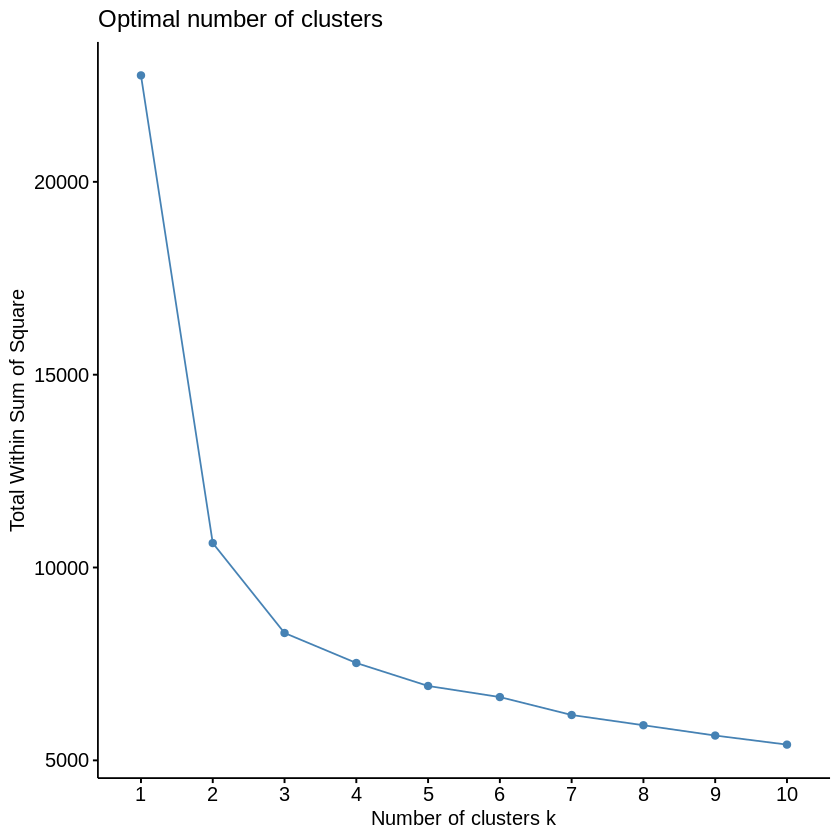

In [0]:
data.pca <- prcomp(data[,vars_num], center = TRUE,scale. = TRUE)
summary(data.pca)

data[,vars_num] %>%
  scale() %>%
  fviz_nbclust(kmeans, method = "wss")


Nu laves en hurtig k-means analyse, hvor vi illustrere resultatet igennem et biplot med Pos grupperingen vist. 

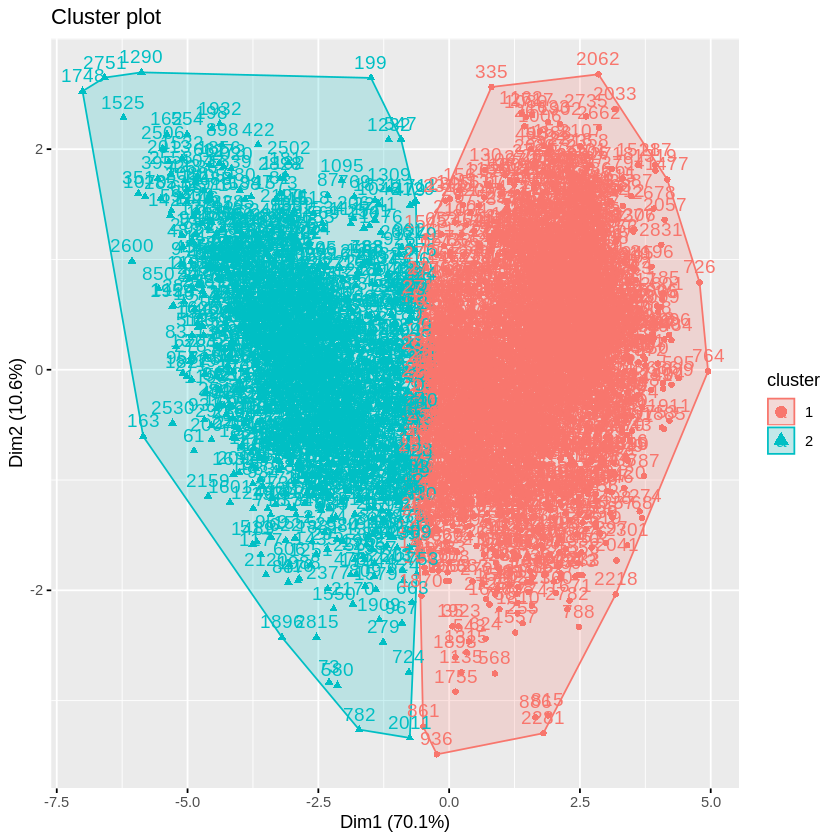

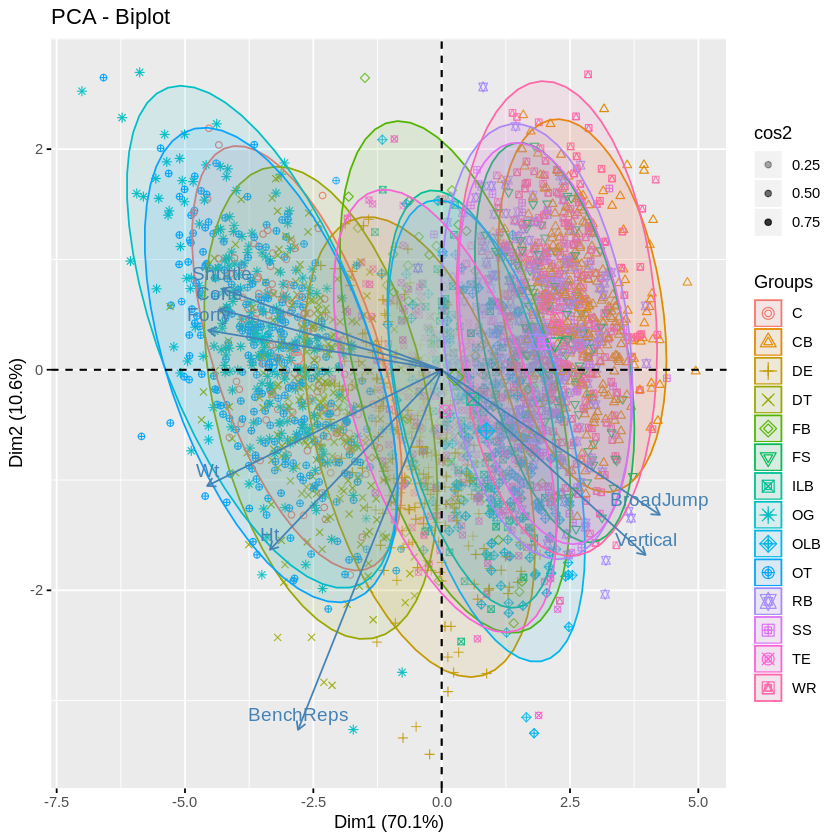

In [0]:
km <- data[,vars_num] %>% 
  scale() %>% 
  kmeans( centers = 2, nstart = 2)  

km %>% 
  fviz_cluster(data = data[,vars_num],
               ggtheme = theme_gray()) 

data.pca %>% 
  fviz_pca_biplot(alpha.ind = "cos2",
                  geom = "point",                   
                  habillage = data$Pos %>% factor(), 
                  addEllipses = TRUE,
                  ggtheme = theme_gray()) 

Noter, Forty, Shuttle og Cone er adræt og opmærksomhedstest som er målt i sekunder, jo flere sekunder jo langsommere er man. Dette tager plottet ikke hensyn til. Dvs. at selvom man kunne få opfattelsen af at Forty, Cone og Shuttle hører til blandt de venstre grupperinger, så er dem som er gode til disse øvelser, de højre grupperinger, altså WR, TE, CB etc.

# *DEL 1.2 - Supervised ML analyse af datasæt, UDEN kombination af positioner*

Her laves en supervised ML analyse, uden kombination af positioner. 
Her laves noget preprocessing i form af at splitte dataet. Noter at der splittes 90%/10%, dette er med fuld belæg. Den normale fordeling er 75%/25% eller 80%/20%. Der vil gerne laves en model der er så nøjagtig så muligt, dog behøves vi ikke så mange observationer for at verficere vores model, herved laves en 90%/10% analyse. 

Efter splittet set vi på antal observationer i training og test datasættet.


In [0]:
data %<>% drop_na %>% select(Pos, everything())

index <- createDataPartition(y = data$Pos, p = 0.90, list = FALSE) # 75% to 25% split

training <- data[index,]
test <- data[-index,]

nrow(training)
nrow(test)

reci <- recipe(Pos ~ ., data = training) %>%
  step_center(all_numeric(), -all_outcomes()) %>% # Centers all numeric variables to mean = 0
  step_scale(all_numeric(), -all_outcomes()) %>% # scales all numeric variables to sd = 1
  step_zv(all_predictors())  # Removed predictors with zero variance


# knn inputation of missing values
reci %<>%
  step_knnimpute(all_predictors()) 

# Recipe in the end has to be prepared on the training data
reci %<>% 
  prep(data = training)

reci

[1] 2567

[1] 279

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 2567 data points and no missing data.

Operations:

Centering for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Scaling for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Zero variance filter removed no terms [trained]
K-nearest neighbor imputation for Wt, Forty, Vertical, BenchReps, ... [trained]

Nu definerer vi kontrol features, er er valgt 2-fold crossvalidation, grundet datasættets størrelse. Herefter bages datasættet. Head() funktionen tages på det bagte datasæt og ser på antal levels i Pos variablen, for at være sikker på, at training og test har lige mange levels. Teoretisk set kunne der være positioner som kun kom med i det ene datasæt grundet fordelingen. Her verificeres at begge datasæt har samme antal positioner (levels).

In [0]:
x_train <- bake(reci, new_data = training) %>% select(-Pos) 
y_train <- pull(training, Pos) %>% as.factor()

# test: split in y and x
x_test <- bake(reci, new_data = test) %>% select(-Pos) 
y_test  <- pull(test, Pos) %>% as.factor()


ctrl <- trainControl(method = "cv", # repeatedcv, boot, cv, LOOCV, timeslice OR adaptive etc.
                     number = 2, # Number of CV's
                     classProbs = TRUE, # Include probability of class prediction
                     savePredictions = TRUE, # Save the prediction results
                     summaryFunction = multiClassSummary, # Which type of summary statistics to deliver
                     verboseIter = FALSE,
                     # add adaptive resampling for hyperparamether search
                     adaptive = list(min = 3, 
                                     alpha = 0.05, 
                                     method = "gls", 
                                     complete = TRUE),
                     search = "random" )

metric <- "Accuracy" # Which metric should be optimized (more on that later)
n_tune = 2 # number of tuning rounds

#x_train$Type1 <- as.character(x_train$Type1)

x_train <- cbind(Number = rownames(x_train), x_train)
x_train$Number <- as.numeric(x_train$Number)


x_test <- cbind(Number = rownames(x_test), x_test)
x_test$Number <- as.numeric(x_test$Number)

x_train %>% head()
y_train %>% head()
x_test %>% head()
y_test %>% head()

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7409944,-0.3306905,-0.2798700,-0.3725741,-0.01485372,-0.13055261,1.5071523,-0.06949868
1112,1.4990048,1.3042491,1.6491255,-1.0695724,-0.17048433,-1.80305937,0.9544218,1.18686130
1791,-0.7409944,-0.9628671,-0.5909983,0.5567569,-1.72679046,0.07851074,-0.8880131,-0.32816103
1902,-1.4876609,-1.1590599,-1.1510293,1.1375888,-0.79300679,0.28757408,-1.1413479,-1.36281043
2013,-0.3676612,-0.9846663,-0.5909983,1.6022543,-0.94863740,0.60116910,-1.9013523,-0.43901632
2124,0.7523384,1.0862572,0.8090790,-0.2564078,-0.63737617,-1.07133766,1.0465436,0.63258484


[1] OLB OT  FS  CB  FS  OG 
Levels: C CB DE DT FB FS ILB OG OLB OT RB SS TE WR

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7523384,1.78383144,2.3336077,-1.7665707,0.2964075,-2.0121227,2.7047350,2.1106554
112,-1.8609941,-1.68224057,-1.1510293,0.5567569,-0.6373762,0.6011691,-0.6346783,-0.9932928
203,0.7523384,1.23885156,1.1824330,-0.9534060,1.0745606,-1.4894643,1.1847262,1.0760060
214,-1.4876609,-0.81027277,-0.7776753,1.3699216,-0.7930068,1.5419542,-1.0722566,-0.7715822
225,0.3790052,1.34784754,0.5601764,-0.2564078,-0.3261149,-1.2804010,0.2174479,0.5956331
236,0.3790052,0.01809664,0.4979507,-0.2564078,-0.1704843,-0.4441476,-0.4274043,-0.7346304


[1] OT  CB  DT  RB  DT  OLB
Levels: C CB DE DT FB FS ILB OG OLB OT RB SS TE WR

Nu begynder fitningen af den supervised ML analyse, her fittes i k-nearest neighbor classification fit, et decision tree fit og en random forest fit. Disse 3 er udvalgt på baggrund af deres multiklassifikation og validitet. 

Vi fitter nu k-nearest neighbor classification fittet og viser den igennem en confusionmatrix. Confusionmatrix er valgt grundet dets mulighed for, at vise faktiske og predikterede værdier. Hvilket vi kan konkludere på. 

In [0]:
fit_kknn <- train(x = x_train, 
                 y = y_train, 
                 trControl = ctrl, 
                 metric = metric,
                 method = "kknn") 

fit_kknn

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

2567 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'FS', 'ILB', 'OG', 'OLB', 'OT', 'RB', 'SS', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1283, 1284 
Resampling results across tuning parameters:

  kmax  distance  kernel    logLoss   AUC        prAUC      Accuracy 
  197   1.855204  gaussian  1.397431  0.9204170  0.4323536  0.4885075
  323   2.336792  cos       1.396426  0.9160557  0.4149024  0.4814945
  617   2.863489  gaussian  1.567616  0.9107436  0.4058964  0.4705865
  Kappa      Mean_F1    Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value
  0.4382725  0.3850799  0.3996697         0.9599182         0.4534124          
  0.4307119  0.3899025  0.3939925         0.9593815         0.4321423          
  0.4189529  0.3747198  0.3861591         0.9585509         0.4384333          
  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall  Mean_Detection_Rate
  0.9606360            0.4534124       

In [0]:
pred_kknn <- predict(fit_kknn, newdata = x_test)
confusionMatrix(pred_kknn, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB FS ILB OG OLB OT RB SS TE WR
       C    3  0  0  3  0  0   0  1   0  0  0  0  0  0
       CB   0 25  0  0  0  5   0  0   0  0  6  3  0 12
       DE   0  0 15  3  2  0   0  1   7  0  0  0  8  0
       DT   2  0  0 11  0  0   0  4   0  1  0  0  0  0
       FB   0  0  0  1  1  0   0  0   0  0  0  0  0  0
       FS   0  0  0  0  0  1   0  0   0  0  1  1  0  1
       ILB  0  0  0  0  1  0   1  0   0  0  1  0  0  0
       OG   4  0  0  2  1  0   0  4   0  2  0  0  0  0
       OLB  0  0  6  0  1  1  10  0  11  0  3  0  5  0
       OT   2  0  3  5  0  0   0 12   0 24  0  0  0  0
       RB   0  3  0  0  1  2   1  0   4  0 11  3  0  1
       SS   0  0  0  0  0  1   0  0   0  0  0  0  0  0
       TE   0  0  3  0  0  0   0  0   2  0  0  0  6  0
       WR   0  3  0  0  0  2   1  0   0  0  2  3  0 13

Overall Statistics
                                         
               Accuracy : 0.4516         
                 9

Modellens nøjagtighed er 45.16%, hvilket vil sige, at 45.16% af prediktionerne er korrekte. Dog ses det at mange af fejlene skyldes, at positionerne ligner hinanden såsom cornerback og widereceiver, DE og tightend samt OLB og ILB. Som "praktisk set" kræver samme fysiske udfoldelser. Dette forsøges at korrigeres for, i mindre form, igennem analyse 2. 

Vi fitter nu en decision tree model og predikter den, det vises igennem et confusion matrix.

In [0]:
fit_dt <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl, 
                metric = metric,
                tuneLength = n_tune,
                method = "rpart") 

fit_dt

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

CART 

2567 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'FS', 'ILB', 'OG', 'OLB', 'OT', 'RB', 'SS', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1281, 1286 
Resampling results across tuning parameters:

  cp           logLoss   AUC        prAUC      Accuracy   Kappa      Mean_F1
  0.000437254  3.965626  0.8846183  0.3118006  0.4955007  0.4504793  0.43183
  0.002769276  2.132450  0.9045885  0.2704162  0.5227715  0.4780886      NaN
  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value
  0.4365649         0.9609466         0.4390437            0.9610922          
  0.4465223         0.9628395         0.4387276            0.9633738          
  Mean_Precision  Mean_Recall  Mean_Detection_Rate  Mean_Balanced_Accuracy
  0.4390437       0.4365649    0.03539291           0.6987558             
  0.4387276       0.4465223    0.03734082           0.7046809             

Accuracy was used to select the 

In [0]:
pred_dt <- predict(fit_dt, newdata = x_test)
confusionMatrix(pred_dt, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB FS ILB OG OLB OT RB SS TE WR
       C    1  0  0  4  0  0   0  0   0  0  0  0  0  0
       CB   0 25  0  0  0  6   0  0   0  0  1  3  0 11
       DE   0  0 16  3  2  0   0  0   4  0  0  0  8  0
       DT   3  0  1 13  0  0   0  5   0  0  0  0  0  0
       FB   0  0  0  0  0  0   0  0   0  0  0  0  0  0
       FS   0  2  0  0  0  2   0  0   0  0  0  1  0  2
       ILB  0  0  3  0  2  0   4  0   1  0  0  0  0  0
       OG   5  0  0  4  0  0   0 13   0  2  0  0  0  0
       OLB  0  0  0  0  2  0   7  0  12  0  5  0  4  0
       OT   2  0  3  1  0  0   0  4   0 25  0  0  0  0
       RB   0  2  0  0  1  3   2  0   2  0 15  2  0  2
       SS   0  1  0  0  0  0   0  0   0  0  1  2  0  1
       TE   0  0  4  0  0  0   0  0   5  0  0  0  7  0
       WR   0  1  0  0  0  1   0  0   0  0  2  2  0 11

Overall Statistics
                                          
               Accuracy : 0.5233          
                

Her får modellen en nøjagtighed på 52.33%. Samme problem som sidst i form af at positioner af samme fysiske karakteristika bliver sat sammen.

Vi fitter nu en random forest model, og viser prediktionen igennem et confusionmatrix. 

In [0]:
fit_rf <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl,  
                metric = metric,
                tuneLength = n_tune,
                method = "ranger", 
                importance = "impurity", # To define how to measure variable importantce (later more)
                num.trees = 25
                )

fit_rf

Random Forest 

2567 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'FS', 'ILB', 'OG', 'OLB', 'OT', 'RB', 'SS', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1285, 1282 
Resampling results across tuning parameters:

  min.node.size  mtry  logLoss   AUC        prAUC      Accuracy   Kappa    
   9             9     1.617743  0.9300418  0.4847709  0.5446044  0.5024013
  20             3     1.225406  0.9350043  0.4968498  0.5504501  0.5074089
  Mean_F1    Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value
  0.4803860  0.4780504         0.9645599         0.5001607          
  0.4636072  0.4667977         0.9648771         0.5092647          
  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall  Mean_Detection_Rate
  0.9648474            0.5001607       0.4780504    0.03890032         
  0.9654095            0.5092647       0.4667977    0.03931787         
  Mean_Balanced_Accuracy
  0.7213051             
  0.7158374     

In [0]:
pred_rf <- predict(fit_rf, newdata = x_test)
confusionMatrix(pred_rf, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB FS ILB OG OLB OT RB SS TE WR
       C    4  0  0  3  0  0   0  1   0  0  0  0  0  0
       CB   0 24  0  0  0  2   0  0   0  0  1  2  0  9
       DE   0  0 20  3  3  0   0  0   6  0  0  0  3  0
       DT   2  0  1 15  0  0   0  6   0  0  0  0  0  0
       FB   0  0  0  0  1  0   0  0   0  0  0  0  0  0
       FS   0  1  0  0  0  0   0  0   0  0  1  0  0  0
       ILB  0  0  2  0  1  0   2  0   1  0  0  0  0  0
       OG   3  0  0  3  0  0   0 11   0  4  0  0  0  0
       OLB  0  0  0  0  1  0  10  0  10  0  5  0  2  0
       OT   2  0  0  1  0  0   0  4   0 23  0  0  0  0
       RB   0  1  0  0  1  3   1  0   2  0 14  3  0  0
       SS   0  1  0  0  0  1   0  0   0  0  2  0  0  1
       TE   0  0  4  0  0  0   0  0   5  0  0  0 14  0
       WR   0  4  0  0  0  6   0  0   0  0  1  5  0 17

Overall Statistics
                                          
               Accuracy : 0.5556          
                

Her får modellen en nøjagtighed på 55.56% men udviser stadig samme fejltyper som før, dog er denne markant bedre end de resterende modeller. Både i form af fejl, men også hvilken type fejl der forekommer. Se ses mindre spredning i fejl-prediktionen end de forhenværende modeller. 

Her kan vi nu konkludere på datasættet. 

Modellernes "nøjagtighed" er som følgende:
Logaritme model: 52.33%
Decision tree: 50.18%
Random forest: 58.78%

# *DEL 2.1 - Unsurpervised analyse af datasæt, MED kombination af positioner*

Samme analyse som forrige afsnit, dog med det kombinerede datasæt. Derfor beskrives der ikke ligeså intensivt. Her inkluderes EDGE i DE, OLB og ILB i OL, NT i DT, FS og SS i S, og NS i G.

Vi anser datasættet:

In [0]:
data2 %>% glimpse()
data2 %>% head()
sapply(data2, mode)

count(data2$Pos)

Observations: 2,884
Variables: 9
$ Pos       <fct> OT, OL, CB, OT, S, CB, S, OG, OL, DE, S, DT, S, CB, OG, DE,…
$ Ht        <dbl> 76, 72, 69, 78, 72, 70, 73, 76, 74, 76, 73, 76, 70, 71, 77,…
$ Wt        <dbl> 334, 237, 175, 312, 208, 199, 207, 302, 237, 274, 201, 309,…
$ Forty     <dbl> 5.56, 4.72, 4.44, 5.34, 4.62, 4.44, 4.62, 5.07, 4.78, 5.09,…
$ Vertical  <dbl> 25.0, 31.0, 35.0, 28.0, 35.0, 37.5, 39.5, 31.5, 31.5, 29.0,…
$ BenchReps <dbl> 23, 21, 17, 20, 10, 16, 15, 17, 21, 26, 12, 28, 14, 14, 28,…
$ BroadJump <dbl> 94, 112, 119, 96, 114, 116, 119, 103, 111, 105, 115, 99, 11…
$ Cone      <dbl> 8.48, 7.96, 7.03, 7.72, 6.92, 6.81, 6.48, 7.76, 7.17, 7.68,…
$ Shuttle   <dbl> 4.98, 4.39, 4.14, 4.73, 4.32, 4.04, 4.29, 4.58, 4.33, 4.49,…


Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OT,76,334,5.56,25.0,23,94,8.48,4.98
OL,72,237,4.72,31.0,21,112,7.96,4.39
CB,69,175,4.44,35.0,17,119,7.03,4.14
OT,78,312,5.34,28.0,20,96,7.72,4.73
S,72,208,4.62,35.0,10,114,6.92,4.32
CB,70,199,4.44,37.5,16,116,6.81,4.04


Pos        Ht        Wt     Forty  Vertical BenchReps BroadJump      Cone 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
  Shuttle 
"numeric"

x,freq
<fct>,<int>
C,115
CB,311
DE,287
DT,253
FB,77
S,237
G,10
OL,371
OG,224


Vi laver nu en PCA analyse hvor vi finder optimale antal clusters, dette er igen 2:

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.3679 0.9228 0.78906 0.61351 0.46813 0.37178 0.34836
Proportion of Variance 0.7008 0.1065 0.07783 0.04705 0.02739 0.01728 0.01517
Cumulative Proportion  0.7008 0.8073 0.88513 0.93218 0.95957 0.97685 0.99202
                           PC8
Standard deviation     0.25267
Proportion of Variance 0.00798
Cumulative Proportion  1.00000

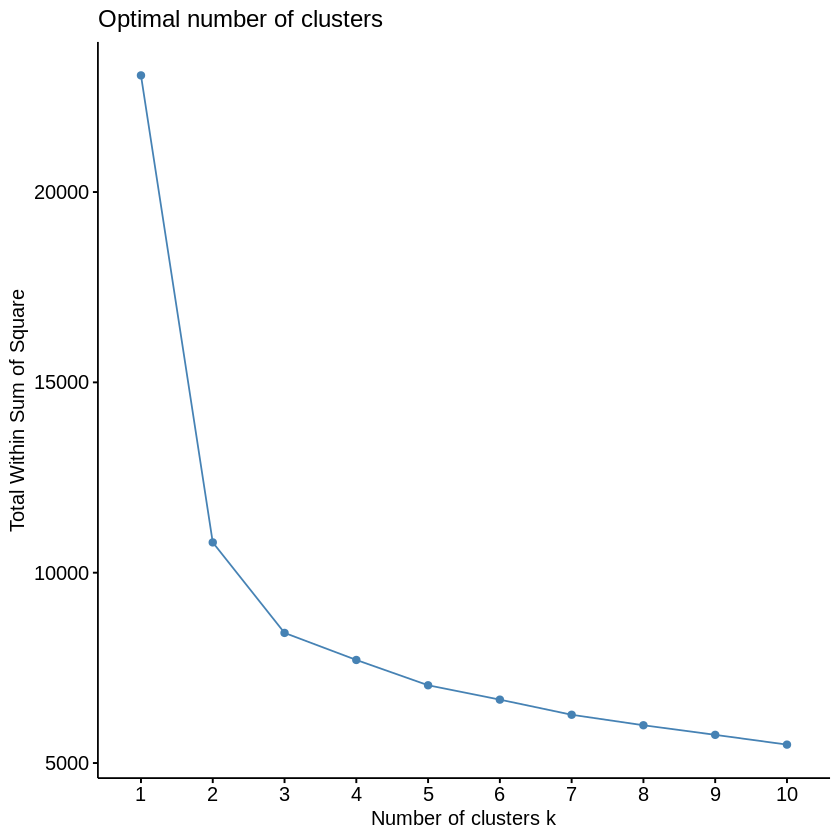

In [0]:
data2.pca <- prcomp(data2[,vars_num], center = TRUE,scale. = TRUE)
summary(data2.pca)

data2[,vars_num] %>%
  scale() %>%
  fviz_nbclust(kmeans, method = "wss")

Kmeans plot med og uden gruppering af Pos.

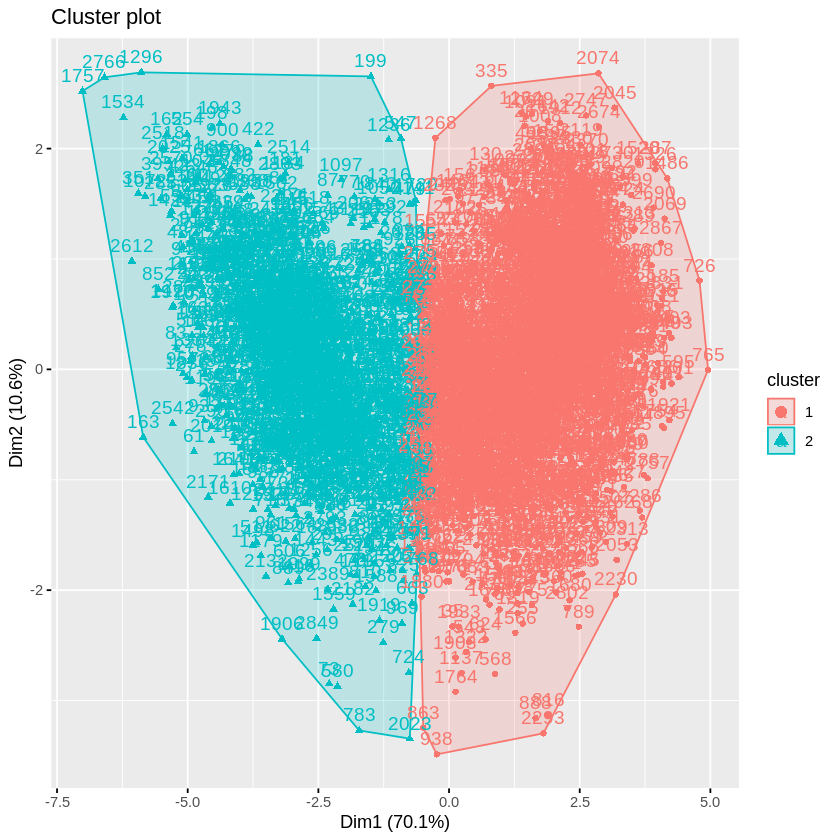

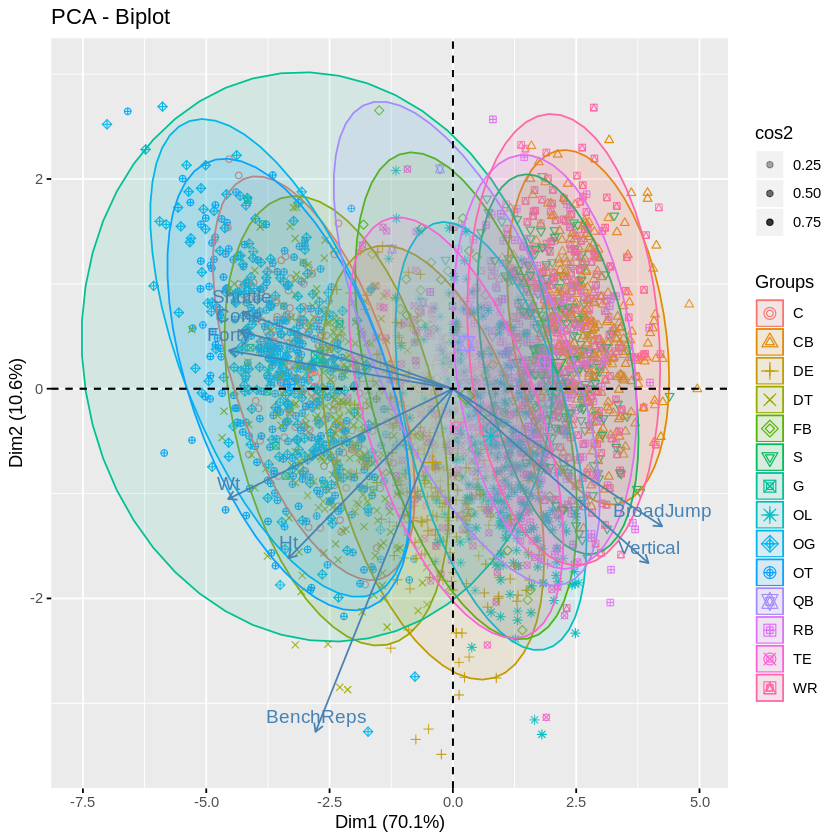

In [0]:
km <- data2[,vars_num] %>% 
  scale() %>% 
  kmeans( centers = 2, nstart = 2)  

km %>% 
  fviz_cluster(data = data2[,vars_num],
               ggtheme = theme_gray())  

data2.pca %>% 
  fviz_pca_biplot(alpha.ind = "cos2",
                  geom = "point",                   
                  habillage = data2$Pos %>% factor(), 
                  addEllipses = TRUE,
                  ggtheme = theme_gray()) 

# *DEL 2.2 - Surpervised analyse af datasæt, MED kombination af positioner*

Vi laver nu noget preprocessing og splitter dataet op. Under samme grundlag som forrige analyse splittes datasættet 90%/10%.

In [0]:
data2 %<>% drop_na %>% select(Pos, everything())
data2 <- droplevels(data2)

index <- createDataPartition(y = data2$Pos, p = 0.90, list = FALSE) # 75% to 25% split

training <- data2[index,]
test <- data2[-index,]

nrow(training)
nrow(test)

reci <- recipe(Pos ~ ., data = training) %>%
  step_center(all_numeric(), -all_outcomes()) %>% # Centers all numeric variables to mean = 0
  step_scale(all_numeric(), -all_outcomes()) %>% # scales all numeric variables to sd = 1
  step_zv(all_predictors())  # Removed predictors with zero variance


# knn inputation of missing values
reci %<>%
  step_knnimpute(all_predictors()) 

# Recipe in the end has to be prepared on the training data
reci %<>% 
  prep(data = training)

reci

[1] 2601

[1] 283

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 2601 data points and no missing data.

Operations:

Centering for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Scaling for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Zero variance filter removed no terms [trained]
K-nearest neighbor imputation for Wt, Forty, Vertical, BenchReps, ... [trained]

Nu definerer vi kontrolfeatures og 2-fold crossvalidation, samt bager og træner datasættet.

In [0]:
x_train <- bake(reci, new_data = training) %>% select(-Pos) 
y_train <- pull(training, Pos) %>% as.factor()

# test: split in y and x
x_test <- bake(reci, new_data = test) %>% select(-Pos) 
y_test  <- pull(test, Pos) %>% as.factor()


ctrl <- trainControl(method = "cv", # repeatedcv, boot, cv, LOOCV, timeslice OR adaptive etc.
                     number = 2, # Number of CV's
                     classProbs = TRUE, # Include probability of class prediction
                     savePredictions = TRUE, # Save the prediction results
                     summaryFunction = multiClassSummary, # Which type of summary statistics to deliver
                     verboseIter = FALSE,
                     # add adaptive resampling for hyperparamether search
                     adaptive = list(min = 3, 
                                     alpha = 0.05, 
                                     method = "gls", 
                                     complete = TRUE),
                     search = "random" )

metric <- "Accuracy" # Which metric should be optimized (more on that later)
n_tune = 2 # number of tuning rounds

#x_train$Type1 <- as.character(x_train$Type1)

x_train <- cbind(Number = rownames(x_train), x_train)
x_train$Number <- as.numeric(x_train$Number)


x_test <- cbind(Number = rownames(x_test), x_test)
x_test$Number <- as.numeric(x_test$Number)

x_train %>% head()
y_train %>% head()
x_test %>% head()
y_test %>% head()

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7502686,1.7861019,2.3334702,-1.7828477,0.29955508,-2.02042107,2.7137166,2.12353821
1112,-0.7448079,-0.3276377,-0.2815446,-0.3732970,-0.01297712,-0.12604113,1.5131435,-0.06777022
1825,1.4978069,1.3066970,1.6485854,-1.0780724,-0.16924321,-1.80993441,0.9590329,1.19501769
1936,-0.7448079,-0.9595805,-0.5928559,0.5664035,-1.73190417,0.08444553,-0.8880026,-0.32775596
2047,-1.4923462,-1.1557007,-1.1532162,1.1537163,-0.79430759,0.29493219,-1.1419700,-1.36769894
2158,-0.3710388,-0.9813716,-0.5928559,1.6235665,-0.95057369,0.61066218,-1.9038721,-0.43917842


[1] OT OL OT S  CB S 
Levels: C CB DE DT FB S G OL OG OT QB RB TE WR

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.86611535,-1.6786878,-1.1532162,0.5664035,-0.6380415,0.6106622,-0.63403523,-0.9962907
112,0.75026862,1.0887857,0.8080449,-0.2558344,-0.6380415,-1.0732311,1.05138466,0.6379054
207,1.87157603,0.3478873,0.7769138,-0.6082221,-1.2631059,-0.5470144,0.05860308,0.9721728
218,0.37649948,1.3502793,0.5589959,-0.2558344,-0.3255093,-1.2837178,0.22021868,0.6007646
229,0.00273034,1.1541591,0.5589959,-0.6082221,2.1747482,-1.2837178,-1.04961822,-0.9220091
240,0.37649948,1.4810261,2.5202570,-1.6653851,0.4558212,-2.0204211,2.78298044,3.0149179


[1] CB OG TE DT DT OG
Levels: C CB DE DT FB S G OL OG OT QB RB TE WR

Vi fitter igennem de samme test som forrige analysen, kknn, decision tree og random forest.

Her fittes kknn modellen. 

In [0]:
fit_kknn <- train(x = x_train, 
                 y = y_train, 
                 trControl = ctrl, 
                 metric = metric,
                 method = "kknn") 

fit_kknn

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

k-Nearest Neighbors 

2601 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'S', 'G', 'OL', 'OG', 'OT', 'QB', 'RB', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1301, 1300 
Resampling results across tuning parameters:

  kmax  distance   kernel       logLoss   AUC        prAUC      Accuracy 
  197   0.8887582  triangular   1.321233  0.9165027  0.4684328  0.5478667
  421   0.5936762  cos          1.322688  0.9122026  0.4674797  0.5544043
  701   2.4221874  rectangular  1.460333  0.8996133  0.3997881  0.4975013
  Kappa      Mean_F1  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value
  0.4977163  NaN      0.4049473         0.9641070         NaN                
  0.5053077  NaN      0.4123160         0.9646553         NaN                
  0.4423809  NaN      0.3707440         0.9601698         NaN                
  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall  Mean_Detection_Rate
  0.9651438            NaN         

Nu laves kknn confusionmatrix.

In [0]:
pred_kknn <- predict(fit_kknn, newdata = x_test)
confusionMatrix(pred_kknn, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB  S  G OL OG OT QB RB TE WR
        C   3  0  0  0  0  0  0  0  0  0  0  0  0  0
        CB  0 27  0  0  0  6  0  0  0  0  0  5  0 11
        DE  0  0 13  1  0  0  0  2  0  0  0  0  7  0
        DT  2  0  1 19  1  0  0  0  3  2  0  0  0  0
        FB  0  0  0  0  1  0  0  0  0  0  0  0  0  0
        S   0  2  0  0  0 10  0  0  0  0  0  4  0  4
        G   0  0  0  0  0  0  0  0  0  0  0  0  0  0
        OL  0  0 10  0  5  0  1 32  0  0  0  3  5  3
        OG  4  0  0  1  0  0  0  0  9  3  0  0  0  0
        OT  2  0  4  4  0  0  0  0 10 22  0  0  0  0
        QB  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        RB  0  0  0  0  0  2  0  2  0  0  0 12  0  0
        TE  0  0  0  0  0  0  0  1  0  0  1  0  7  0
        WR  0  2  0  0  0  5  0  0  0  0  0  0  0  9

Overall Statistics
                                          
               Accuracy : 0.5795          
                 95% CI : (0.5196, 0.6377)
   

Her får modellen en nøjagtighed på 57.95% udviser stadig fejl dog er spredningen af fejlene mindre end analyse 1.

Her fittes decision tree modellen.

In [0]:
fit_dt <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl, 
                metric = metric,
                tuneLength = n_tune,
                method = "rpart") 

fit_dt

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

CART 

2601 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'S', 'G', 'OL', 'OG', 'OT', 'QB', 'RB', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1299, 1302 
Resampling results across tuning parameters:

  cp            logLoss   AUC        prAUC      Accuracy   Kappa      Mean_F1
  0.0006616674  3.127472  0.8557711  0.3121824  0.5251975  0.4762067  NaN    
  0.0039700044  1.783497  0.8611967  0.1642252  0.5490354  0.4998364  NaN    
  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value
  0.4183662         0.9626896         NaN                  0.9629814          
  0.4121005         0.9642931         NaN                  0.9652674          
  Mean_Precision  Mean_Recall  Mean_Detection_Rate  Mean_Balanced_Accuracy
  NaN             0.4183662    0.03751411           0.6905279             
  NaN             0.4121005    0.03921682           0.6881968             

Accuracy was used to select the o

Confusionmatrix laves for decision tree.

In [0]:
pred_dt <- predict(fit_dt, newdata = x_test)
confusionMatrix(pred_dt, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB  S  G OL OG OT QB RB TE WR
        C   0  0  0  0  0  0  0  0  0  0  0  0  0  0
        CB  0 22  0  0  0  1  0  0  0  0  0  2  0  9
        DE  0  0 13  0  0  0  0  1  0  0  0  0  6  0
        DT  5  0  1 24  0  0  0  0  4  2  0  0  0  0
        FB  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        S   0  3  0  0  0  8  0  1  0  0  0  2  0  4
        G   0  0  0  0  0  0  0  0  0  0  0  0  0  0
        OL  0  0  3  0  3  0  1 28  0  0  1  6  3  1
        OG  4  0  0  1  0  0  0  0 13  4  0  0  0  0
        OT  2  0  2  0  0  0  0  0  5 21  0  0  0  0
        QB  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        RB  0  4  0  0  0  7  0  1  0  0  0 12  0  0
        TE  0  0  9  0  4  0  0  6  0  0  0  0 10  0
        WR  0  2  0  0  0  7  0  0  0  0  0  2  0 13

Overall Statistics
                                          
               Accuracy : 0.5795          
                 95% CI : (0.5196, 0.6377)
   

Her får modellen en nøjagtighed på 57.95% udviser stadig fejl dog er spredningen af fejlene mindre end analyse 1. Her er modellen markant bedre end forrige.

Random forest fit:

In [0]:
fit_rf <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl,  
                metric = metric,
                tuneLength = n_tune,
                method = "ranger", 
                importance = "impurity", # To define how to measure variable importantce (later more)
                num.trees = 25
                )

fit_rf

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Random Forest 

2601 samples
   9 predictor
  14 classes: 'C', 'CB', 'DE', 'DT', 'FB', 'S', 'G', 'OL', 'OG', 'OT', 'QB', 'RB', 'TE', 'WR' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1299, 1302 
Resampling results across tuning parameters:

  mtry  logLoss   AUC        prAUC      Accuracy   Kappa      Mean_F1
  1     1.307675  0.9246703  0.4542972  0.5605366  0.5130395  NaN    
  8     1.333126  0.9140509  0.4898229  0.5736015  0.5291339  NaN    
  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value
  0.4225227         0.9652512         NaN                  0.9659042          
  0.4703056         0.9664431         NaN                  0.9667400          
  Mean_Precision  Mean_Recall  Mean_Detection_Rate  Mean_Balanced_Accuracy
  NaN             0.4225227    0.04003833           0.6938870             
  NaN             0.4703056    0.04097153           0.7183743             

Tuning parameter 'splitrule' was held constant a

Igen laves der en random forest confusionmatrix.

In [0]:
pred_rf <- predict(fit_rf, newdata = x_test)
confusionMatrix(pred_rf, y_test, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction  C CB DE DT FB  S  G OL OG OT QB RB TE WR
        C   2  0  0  2  0  0  0  0  4  0  0  0  0  0
        CB  0 24  0  0  0  4  0  0  0  0  0  2  0 11
        DE  0  0 20  0  0  0  0  2  0  0  0  0  5  0
        DT  3  0  2 19  0  0  0  0  1  2  0  0  0  0
        FB  0  0  0  0  4  0  0  2  0  0  0  1  0  0
        S   0  4  0  0  0 11  0  0  0  0  0  4  0  5
        G   0  0  0  0  0  0  0  0  0  0  0  0  0  0
        OL  0  0  4  0  3  0  1 26  0  0  0  2  3  2
        OG  4  0  1  3  0  0  0  0 12  6  0  0  0  0
        OT  2  0  0  1  0  0  0  0  5 19  0  0  0  0
        QB  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        RB  0  1  0  0  0  2  0  4  0  0  0 15  0  0
        TE  0  0  1  0  0  0  0  2  0  0  0  0 11  0
        WR  0  2  0  0  0  6  0  1  0  0  1  0  0  9

Overall Statistics
                                         
               Accuracy : 0.6078         
                 95% CI : (0.5482, 0.665)
    No

Her får modellen en nøjagtighed på 60.78% udviser stadig fejl dog er spredningen af fejlene mindre end analyse 1. Igen er spredningen af fejlene markant mindre end forrige analyse.

Vi kan nu konkludere på datasættet:

Modellernes "nøjagtighed" er som følgende:
K-nearest: % 57.95%
Decision tree: 57.95%
Random forest: 60.78%

Fra første analyse, uden kombination, blev der fundet:

Modellernes "nøjagtighed" er som følgende:
K-nearest: 45.16%
Decision tree: 52.33%
Random forest: 55.56%

Her ses altså et markant bedre resultat end forrige analyse

# *Analyse 3 - Gruppering af position i 3 hovedgrupperinger - Diskurs*

Af ren nysgerrighed vil vi se modellernes supervised performance, hvis grupperingen af Pos var mindre, og opdelt på generelle karakteristika af positionen. Dette er defineret i databladet som "tunge, medium og lette" spillere. Alt efter om man er stor og langsom, medium stor og medium hastighed, eller lille og hurtig. Størrelse er ment i vægt. 

Her laves en hurtig analyse af denne gruppering. Med mest fokus på supervised.

In [0]:
data_gruppering <- read_csv("https://github.com/bande15/sds/raw/master/combine_data.csv")
#Data hvor kombinatiooner er kombineret. EDGE er inkluderet i DE. OLB og ILB er inkluderet i OL. NT er inkluderet i DT. FS og SS er inkluderet i s. NS er inkluderet i G. Tilsidst er LB og P fjernet grundet 1 observation.
data <- data_gruppering %>% select(-Player, -Year, -Team, -AV, -Round, -Pick, -Pfr_ID)
data %<>% mutate(data, Pos = fct_recode(Pos, "Tung" = "C")) %>% mutate(data, Pos = fct_recode(Pos, "Tung" = "DT")) %>% mutate(data, Pos = fct_recode(Pos, "Tung" = "FB")) %>% mutate(data, Pos = fct_recode(Pos, "Tung" = "G")) %>% mutate(data, Pos = fct_recode(Pos, "Tung" = "LS")) %>% mutate(data2, Pos = fct_recode(Pos, "Tung" = "NT")) %>% mutate(data2, Pos = fct_recode(Pos, "Tung" = "OG")) %>% mutate(data, Pos = fct_recode(Pos, "Tung" = "OT")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "DB")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "DE")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "EDGE")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "FS")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "ILB")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "LB")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "OL")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "OLB")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "RB")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "S")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "SS")) %>% mutate(data, Pos = fct_recode(Pos, "Mellem" = "TE")) %>% mutate(data, Pos = fct_recode(Pos, "Lette" = "CB")) %>% mutate(data, Pos = fct_recode(Pos, "Lette" = "K")) %>% mutate(data, Pos = fct_recode(Pos, "Lette" = "P")) %>% mutate(data, Pos = fct_recode(Pos, "Lette" = "QB")) %>% mutate(data, Pos = fct_recode(Pos, "Lette" = "WR")) %>% drop_na()
nrow(data)
count(data$Pos)

Parsed with column specification:
cols(
  Player = col_character(),
  Pos = col_character(),
  Ht = col_double(),
  Wt = col_double(),
  Forty = col_double(),
  Vertical = col_double(),
  BenchReps = col_double(),
  BroadJump = col_double(),
  Cone = col_double(),
  Shuttle = col_double(),
  Year = col_double(),
  Pfr_ID = col_character(),
  AV = col_double(),
  Team = col_character(),
  Round = col_double(),
  Pick = col_double()
)


[1] 2885

x,freq
<fct>,<int>
Tung,952
Lette,598
Mellem,1335


Hurtig unsupervised analyse, vi ser 2 clusters og går med det.

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.3679 0.9228 0.78904 0.61348 0.46811 0.37178 0.34834
Proportion of Variance 0.7009 0.1064 0.07782 0.04704 0.02739 0.01728 0.01517
Cumulative Proportion  0.7009 0.8073 0.88514 0.93218 0.95957 0.97685 0.99202
                           PC8
Standard deviation     0.25266
Proportion of Variance 0.00798
Cumulative Proportion  1.00000

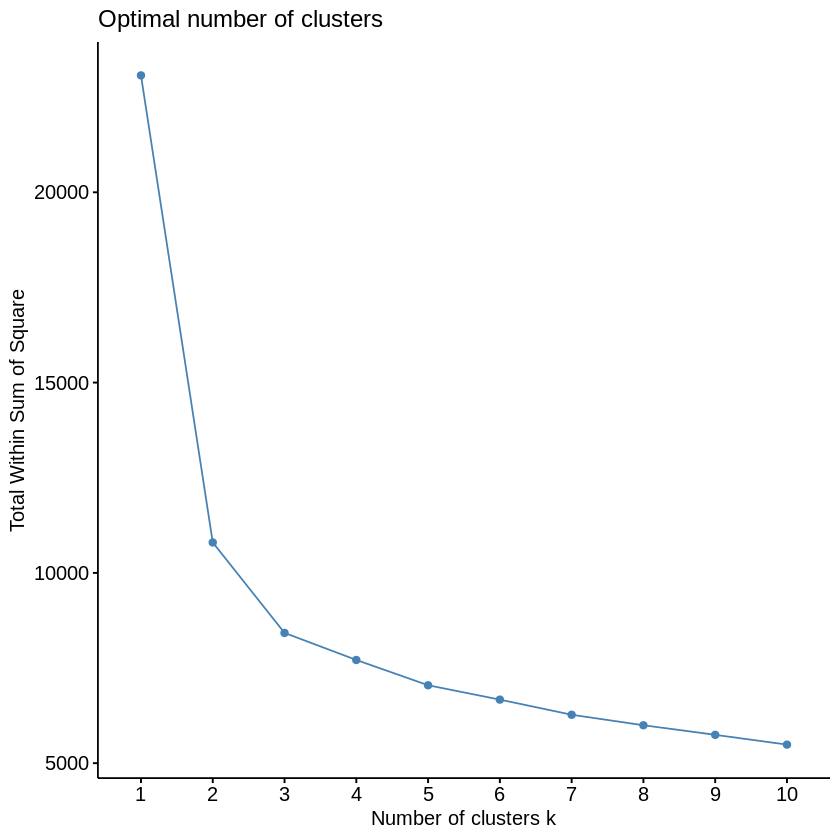

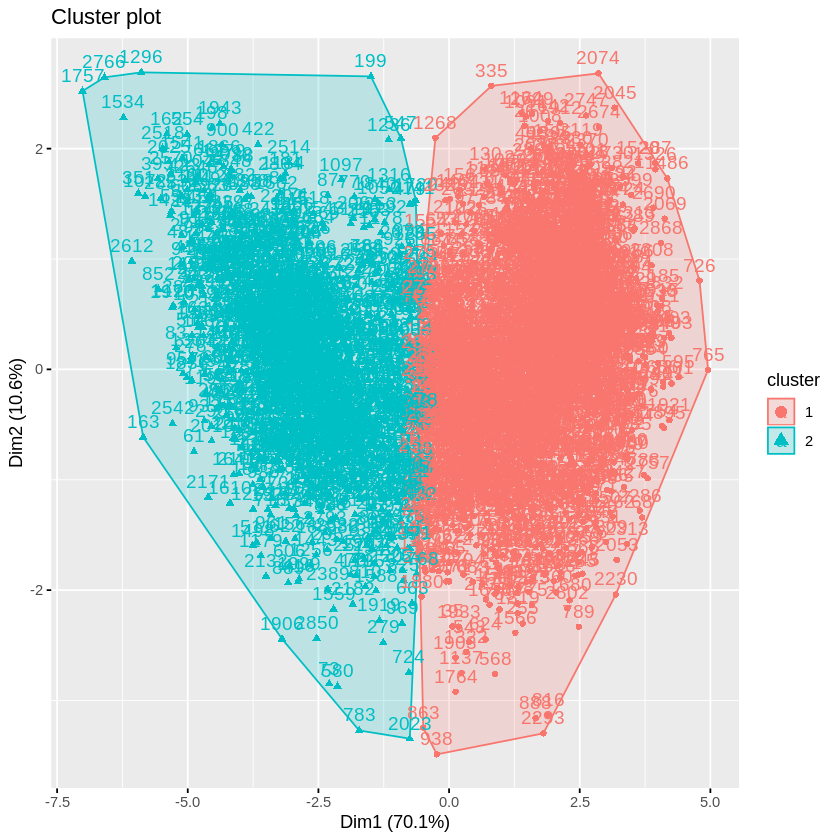

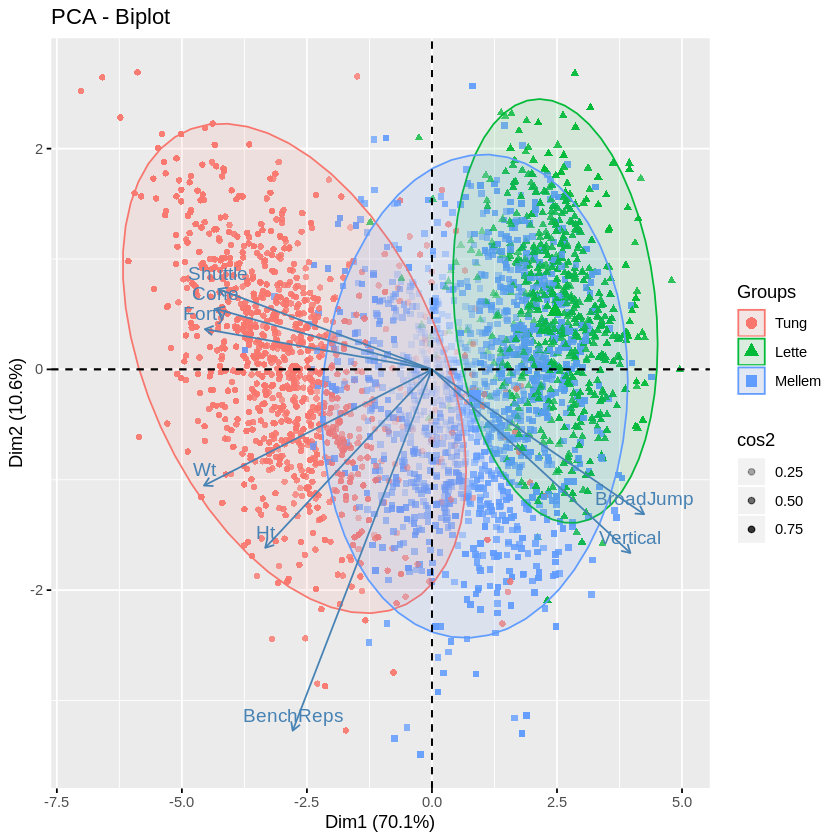

In [0]:
data.pca <- prcomp(data[,vars_num], center = TRUE,scale. = TRUE)
summary(data.pca)

data[,vars_num] %>%
  scale() %>%
  fviz_nbclust(kmeans, method = "wss")

km <- data[,vars_num] %>% 
  scale() %>% 
  kmeans( centers = 2, nstart = 2)  

km %>% 
  fviz_cluster(data = data[,vars_num],
               ggtheme = theme_gray()) 

data.pca %>% 
  fviz_pca_biplot(alpha.ind = "cos2",
                  geom = "point",                   
                  habillage = data$Pos %>% factor(), 
                  addEllipses = TRUE,
                  ggtheme = theme_gray()) 

Her ses en god opdeling som viser de karakteristika som er typiske for spillerne. Her ses at vægt, højde, og lav mobilitet er typisk for de tunge drenge, hvor hurtighed, broadjump og vertical er for de lettere spillere. Som forventet er mellem spillerne mellem disse. 

supervised analyse

In [0]:
data %<>% drop_na %>% select(Pos, everything())

index <- createDataPartition(y = data$Pos, p = 0.90, list = FALSE) # 75% to 25% split

training <- data[index,]
test <- data[-index,]

nrow(training)
nrow(test)

reci <- recipe(Pos ~ ., data = training) %>%
  step_center(all_numeric(), -all_outcomes()) %>% # Centers all numeric variables to mean = 0
  step_scale(all_numeric(), -all_outcomes()) %>% # scales all numeric variables to sd = 1
  step_zv(all_predictors())  # Removed predictors with zero variance


# knn inputation of missing values
reci %<>%
  step_knnimpute(all_predictors()) 

# Recipe in the end has to be prepared on the training data
reci %<>% 
  prep(data = training)

reci

x_train <- bake(reci, new_data = training) %>% select(-Pos) 
y_train <- pull(training, Pos) %>% as.factor()

# test: split in y and x
x_test <- bake(reci, new_data = test) %>% select(-Pos) 
y_test  <- pull(test, Pos) %>% as.factor()


ctrl <- trainControl(method = "cv", # repeatedcv, boot, cv, LOOCV, timeslice OR adaptive etc.
                     number = 2, # Number of CV's
                     classProbs = TRUE, # Include probability of class prediction
                     savePredictions = TRUE, # Save the prediction results
                     summaryFunction = multiClassSummary, # Which type of summary statistics to deliver
                     verboseIter = FALSE,
                     # add adaptive resampling for hyperparamether search
                     adaptive = list(min = 3, 
                                     alpha = 0.05, 
                                     method = "gls", 
                                     complete = TRUE),
                     search = "random" )

metric <- "Accuracy" # Which metric should be optimized (more on that later)
n_tune = 2 # number of tuning rounds

#x_train$Type1 <- as.character(x_train$Type1)

x_train <- cbind(Number = rownames(x_train), x_train)
x_train$Number <- as.numeric(x_train$Number)


x_test <- cbind(Number = rownames(x_test), x_test)
x_test$Number <- as.numeric(x_test$Number)

x_train %>% head()
y_train %>% head()
x_test %>% head()
y_test %>% head()

[1] 2598

[1] 287

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 2598 data points and no missing data.

Operations:

Centering for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Scaling for Ht, Wt, Forty, Vertical, BenchReps, ... [trained]
Zero variance filter removed no terms [trained]
K-nearest neighbor imputation for Wt, Forty, Vertical, BenchReps, ... [trained]

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7492943500,-0.3266337,-0.28281573,-0.3832175,-0.01079319,-0.13057085,1.5362145,-0.06009228
1112,-1.8738851769,-1.6798448,-1.15422696,0.5607019,-0.63392027,0.60618419,-0.6371083,-0.99226171
1822,1.4998873038,1.3103152,1.64673770,-1.0911570,-0.16657496,-1.81458239,0.9753570,1.20765815
1933,-0.7492943500,-0.9595873,-0.59403403,0.5607019,-1.72439266,0.07993059,-0.8941680,-0.32109972
2044,-1.4990215680,-1.1560212,-1.15422696,1.1506515,-0.78970204,0.29043203,-1.1512277,-1.36512948
2155,0.0004328679,-0.3266337,-0.09608476,-0.2652275,-0.01079319,-0.23582157,-0.3099414,-0.28381294


[1] Mellem Lette  Tung   Mellem Lette  Mellem
Levels: Tung Lette Mellem

Number,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7501601,1.7904869,2.3314180,-1.7990965,0.3007703,-2.0250838,2.7514058,2.13982758
112,-0.3744307,-0.9814133,-0.5940340,1.6226112,-0.9454838,0.6061842,-1.9224067,-0.43296005
211,0.7501601,1.0920554,0.8064483,-0.2652275,-0.6339203,-1.0778273,1.0688333,0.64835649
222,-1.1241580,-1.0905432,-0.8741305,0.7966818,-1.1012656,0.3956828,-0.2865723,-0.06009228
233,-2.2487488,-1.3524550,-0.9674960,1.9765810,-0.7897020,0.8166856,-1.2914420,-0.80582782
244,-0.3744307,0.6773617,1.3666412,-1.2091469,0.6123339,-0.5515737,1.5829526,0.90936393


[1] Tung   Mellem Tung   Lette  Mellem Tung  
Levels: Tung Lette Mellem

Vi notere at det er de korrekte 3 levels og fitter vores 3 modeller på kknn, decision tree og random forest. 

In [0]:
fit_kknn <- train(x = x_train, 
                 y = y_train, 
                 trControl = ctrl, 
                 metric = metric,
                 method = "kknn") 

fit_kknn

pred_kknn <- predict(fit_kknn, newdata = x_test)
confusionMatrix(pred_kknn, y_test, positive = "Yes")

fit_dt <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl, 
                metric = metric,
                tuneLength = n_tune,
                method = "rpart") 

fit_dt

pred_dt <- predict(fit_dt, newdata = x_test)
confusionMatrix(pred_dt, y_test, positive = "Yes")

fit_rf <- train(x = x_train, 
                y = y_train, 
                trControl = ctrl,  
                metric = metric,
                tuneLength = n_tune,
                method = "ranger", 
                importance = "impurity", # To define how to measure variable importantce (later more)
                num.trees = 25
                )

fit_rf

pred_rf <- predict(fit_rf, newdata = x_test)
confusionMatrix(pred_rf, y_test, positive = "Yes")

k-Nearest Neighbors 

2598 samples
   9 predictor
   3 classes: 'Tung', 'Lette', 'Mellem' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1299, 1299 
Resampling results across tuning parameters:

  kmax  distance   kernel        logLoss    AUC        prAUC      Accuracy 
   76   1.3279363  triweight     0.4076294  0.9545936  0.7603372  0.8483449
  112   1.5114938  epanechnikov  0.4571311  0.9544758  0.7083047  0.8537336
  577   0.9728319  biweight      0.3852737  0.9561699  0.7515740  0.8533487
  Kappa      Mean_F1    Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value
  0.7599110  0.8383209  0.8354543         0.9181129         0.8424653          
  0.7682128  0.8444027  0.8408188         0.9206384         0.8492123          
  0.7676788  0.8437050  0.8403081         0.9205836         0.8482853          
  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall  Mean_Detection_Rate
  0.9193444            0.8424653       0.8354543    0.2827816          
 

Confusion Matrix and Statistics

          Reference
Prediction Tung Lette Mellem
    Tung     89     0      6
    Lette     0    41     10
    Mellem    6    18    117

Overall Statistics
                                          
               Accuracy : 0.8606          
                 95% CI : (0.8151, 0.8985)
    No Information Rate : 0.4634          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7774          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Tung Class: Lette Class: Mellem
Sensitivity               0.9368       0.6949        0.8797
Specificity               0.9688       0.9561        0.8442
Pos Pred Value            0.9368       0.8039        0.8298
Neg Pred Value            0.9688       0.9237        0.8904
Prevalence                0.3310       0.2056        0.4634
Detection Rate            0.3101       0.

CART 

2598 samples
   9 predictor
   3 classes: 'Tung', 'Lette', 'Mellem' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1299, 1299 
Resampling results across tuning parameters:

  cp           logLoss    AUC        prAUC      Accuracy   Kappa      Mean_F1  
  0.001790831  0.4878932  0.9428719  0.4760125  0.8633564  0.7841136  0.8549982
  0.005372493  0.3881895  0.9402665  0.4948626  0.8598922  0.7779782  0.8501810
  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value
  0.8536216         0.926575          0.8572340            0.9272896          
  0.8463887         0.924010          0.8559795            0.9258918          
  Mean_Precision  Mean_Recall  Mean_Detection_Rate  Mean_Balanced_Accuracy
  0.8572340       0.8536216    0.2877855            0.8900983             
  0.8559795       0.8463887    0.2866307            0.8851994             

Accuracy was used to select the optimal model using the largest value.
The final 

Confusion Matrix and Statistics

          Reference
Prediction Tung Lette Mellem
    Tung     89     0      6
    Lette     0    49      7
    Mellem    6    10    120

Overall Statistics
                                          
               Accuracy : 0.899           
                 95% CI : (0.8581, 0.9313)
    No Information Rate : 0.4634          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8398          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Tung Class: Lette Class: Mellem
Sensitivity               0.9368       0.8305        0.9023
Specificity               0.9688       0.9693        0.8961
Pos Pred Value            0.9368       0.8750        0.8824
Neg Pred Value            0.9688       0.9567        0.9139
Prevalence                0.3310       0.2056        0.4634
Detection Rate            0.3101       0.

Random Forest 

2598 samples
   9 predictor
   3 classes: 'Tung', 'Lette', 'Mellem' 

No pre-processing
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 1298, 1300 
Resampling results across tuning parameters:

  min.node.size  mtry  logLoss    AUC        prAUC      Accuracy   Kappa    
  15             1     0.3803556  0.9575077  0.8107314  0.8687454  0.7909878
  16             8     0.4169018  0.9620798  0.6116421  0.8764454  0.8044356
  Mean_F1    Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value
  0.8587194  0.8512592         0.9274497         0.8684225          
  0.8690980  0.8663462         0.9330014         0.8729465          
  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall  Mean_Detection_Rate
  0.9314804            0.8684225       0.8512592    0.2895818          
  0.9344728            0.8729465       0.8663462    0.2921485          
  Mean_Balanced_Accuracy
  0.8893544             
  0.8996738             

Tuning parameter 'splitrule' was held constan

Confusion Matrix and Statistics

          Reference
Prediction Tung Lette Mellem
    Tung     88     0      4
    Lette     0    45      7
    Mellem    7    14    122

Overall Statistics
                                          
               Accuracy : 0.8885          
                 95% CI : (0.8463, 0.9225)
    No Information Rate : 0.4634          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8218          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Tung Class: Lette Class: Mellem
Sensitivity               0.9263       0.7627        0.9173
Specificity               0.9792       0.9693        0.8636
Pos Pred Value            0.9565       0.8654        0.8531
Neg Pred Value            0.9641       0.9404        0.9236
Prevalence                0.3310       0.2056        0.4634
Detection Rate            0.3066       0.

Her ses kknn at have en nøjagtighed på 86.06% hvor de fleste fejl går mellem tung og mellem og mellem og let, der er altså ingen fejl mellem let og tung. 

Decision tree ses at have en nøjagtighed på 89.9%, hvor samme fejl opstår som ved kknn. 

Til sidst ses random forest at have en nøjagtighed på 88.85%, igen opstår der ingen fejl mellem tung og let. 

Disse er en markant forbedring fra de forrige analyser, dog viser dette også den bias der ligger for analyserne. 
Denne analyse er et diskurs afsnit fordi man ikke kan konkludere positioner på vegne af disse, dog kan man konkludere hvilken gruppering en person ligger i. 

Dermed er vi gået fra en fri analyse uden kombination, til en analyse med mindre kombinationer af undergrupperinger til en analyse med hårdt opstillede grupperinger af positionerne. 